# 2: Train XGBoost Model

Author: Daniel Lusk

## Imports and configuration

In [20]:
import geopandas as gpd
import numpy as np
import spacv
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from spacv.visualisation import plot_autocorrelation_ranges
from TrainModelConfig import TrainModelConfig
from utils.data_retrieval import all_gdfs
from utils.geodata import drop_XY_NAs, merge_gdfs
from utils.visualize import plot_splits

%load_ext autoreload
%autoreload 2

config = TrainModelConfig()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [21]:
X_fns = config.WC_fns + config.MODIS_fns + config.soil_fns
Y_fns = config.iNat_fns

X = all_gdfs(X_fns)
Y = all_gdfs(Y_fns)

Compute Preciptation Annual Range by subtracting BIO14 from BIO13

In [22]:
bio_13 = X.loc[:, ["bio_13" in x for x in X.columns]].values
bio_14 = X.loc[:, ["bio_14" in x for x in X.columns]].values
X["wc2.1_10m_bio_13-14"] = bio_13 - bio_14

Drop the unnecessary `x`, `y`, `band` and `spatial_ref` columns.

In [23]:
X = X.drop(columns=["x", "y", "band", "spatial_ref"])
Y = Y.drop(columns=["x", "y", "band", "spatial_ref"])

## XGBoost

<div class="alert alert-block alert-info">
To-Dos:

1) ~~Create a data frame where you have all response variables and predictors.~~
2) ~~Remove cells where you do not have a value for ANY predictor/response variable (you still may have NA for some columns then).~~
3) Train the models and do the evaluation
4) Repeat step 3, but remove rows where you have at least one NA
5) Compare accuracies of step 3 and 4 and see what´s best.
</div>

### Combine GDFs and clean up nodata

Get column names for easier predictor/response variable selection.

In [24]:
X_cols = X.columns.difference(["geometry"])
Y_cols = Y.columns.difference(["geometry"])

Merge X and Y GDFs

In [25]:
XY = merge_gdfs([X, Y])
print("X shape:", XY[X_cols].shape)
print("Y shape:", XY[Y_cols].shape)

X shape: (259200, 129)
Y shape: (259200, 18)


Drop all-NA rows and columns

In [26]:
XY, X_cols, Y_cols = drop_XY_NAs(XY, X_cols, Y_cols, True)

XY shape before: (259200, 148)
XY shape after: (26183, 147)
# of rows excluded: 233017 (89.90%)

Empty columns:
X: ['soc_60-100cm_mean_0.5_deg'] 
Y: []


### Calculate autocorrelation range of predictors and generate spatial folds for spatial cross-validation

#### Calculate autocorrelation ranges and use the median range as the cell size (may take a while)

In [35]:
DEGREE = 111325  # Standard value for 1 degree in meters at the equator

if config.SAVE_AUTOCORRELATION_RANGES:
    coords = XY["geometry"]
    data = XY[X_cols]
    upper = np.round(DEGREE * 120)
    step = np.round(upper / 30)
    bw = step // 2
    lags = np.arange(0, upper, step)
    
    _, _, ranges = plot_autocorrelation_ranges(
        coords, data, lags, bw, distance_metric="haversine", workers=10
    )

    np.save("ranges.npy", np.asarray(ranges))
else:
    ranges = np.load("ranges.npy")

autocorrelation_range = np.median(ranges)
print(f"Median range (km): {autocorrelation_range / 1000:.2f}")
print(f"Median range (deg): {autocorrelation_range / DEGREE:.2f}")

Median range (km): 2330.63
Median range (deg): 20.94


#### Explore splits for a single response variable

In [38]:
sample_Xy = XY[["geometry", *X_cols, Y_cols[0]]]

sample_Xy, sample_X_cols, sample_y_col = drop_XY_NAs(
    sample_Xy, X_cols, Y_cols[:1], True
)

XY shape before dropping full-NA rows/cols: (26183, 130)
XY shape after:                             (12061, 130)
# of rows excluded: 14122 (53.94%)

 No columns were dropped.


Tile size: 20.94 degrees


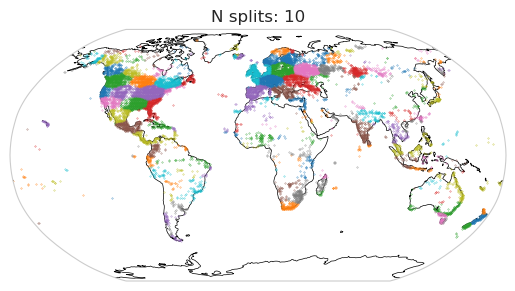

In [40]:
# Sample X data on which split dissimilarity will be measured
sample_data = sample_Xy[sample_X_cols]
sample_locs = sample_Xy["geometry"]

# Grid settings
tile = autocorrelation_range / DEGREE
tiles_x = int(np.round(360 / tile))
tiles_y = int(np.round(180 / tile))

# Spatial blocking
hblock = spacv.HBLOCK(
    tiles_x,
    tiles_y,
    shape="hex",
    method="optimized_random",
    buffer_radius=0.5,
    n_groups=10,
    data=sample_data,
    n_sims=50,
    distance_metric="haversine",
    random_state=config.RNG_STATE,
)

# Plot splits
print(f"Tile size: {tile:.2f} degrees")
plot_splits(hblock, sample_locs)

### Train models for each response variable

In [ ]:
for y_col in Y_cols:
    Xy = XY[[*X_cols, y_col]]
    
    # Drop lingering all-NAs
    Xy = Xy.dropna(axis=0, how="all")
    Xy = Xy.dropna(axis=1, how="all")

    # Separate the dataframes
    y = Xy[y_col]  # Current response variable
    X_y = Xy[X_cols]  # X predictor matrix matched to current response variable
    
    # Spatially block data into cells according to the autocorrelation range and
    # separate them into K folds
    degree = 111.325
    tile = autocorrelation_range / degree
    tiles_x = int(np.round(360 / tile))
    tiles_y = int(np.round(180 / tile))
    
    hblock = spacv.HBLOCK(
        tiles_x,
        tiles_y,
        shape="hex",
        method="optimized_random",
        buffer_radius=0.5,
        n_groups=10,
        data=X_y,
        n_sims=50,
        distance_metric="haversine",
        random_state=config.RNG_STATE
    )

<p><h3>4. Divide into geographic splits for spatial K-fold cross-validation</h3></p>

#### 4.1 Generate variograms to determine block size

Drop column`soc_60-100cm_mean_0.5_deg` because it contains all NaNs

In [ ]:
X = X.dropna(axis=1, how="all")

Get median autocorrelation range of all predictors

In [ ]:
if config.SAVE_AUTOCORRELATION_RANGES:
    XYs = X["geometry"]
    degree = 111.325
    upper = np.round(degree * 120)
    step = np.round(degree * 6)
    bw = step // 2
    lags = np.arange(0, upper, step)

    ranges = plot_autocorrelation_ranges(
        XYs, X[X.columns.difference(["geometry"])], lags, bw, dist_func="haversine"
    )

    np.save("ranges.npy", np.asarray(ranges))
else:
    ranges = np.load("ranges.npy")

print("Median range:", np.median(ranges))

#### 4.2 Plot splits using median autocorrelation range

In [ ]:
XYs = X["geometry"]
med = 2521.42
degree = 111.325
tile = med / degree
tiles_x = int(np.round(360 / tile))
tiles_y = int(np.round(180 / tile))

hblock = spacv.HBLOCK(
    tiles_x,
    tiles_y,
    shape="hex",
    method="optimized_random",
    buffer_radius=0.5,
    n_groups=10,
    data=X[X.columns.difference(["geometry"])],
    n_sims=50,
    distance_metric="haversine",
    random_state=config.RNG_STATE
)

plot_splits(hblock, XYs)

### </p>5. Identify optimal parameters with `GridSearchCV`</p>

In [ ]:
X_np = X[X.columns.difference(["geometry"])].to_numpy()
Y_np = Y[Y.columns.difference(["geometry"])].to_numpy()

In [ ]:
D_X = xgb.DMatrix(X_np)
D_Y = xgb.DMatrix(Y_np)

In [ ]:
print("Parameter optimization")
xgb_model = xgb.XGBRegressor(n_jobs=2)
clf = GridSearchCV(
    xgb_model,
    {"max_depth": [2], "n_estimators": [105]},
    verbose=1,
    n_jobs=2,
    cv=hblock.split(XYs),
)
clf.fit(X_np, Y_np)
print(clf.best_score_)
print(clf.best_params_)

```shell
Parameter optimization
Fitting 10 folds for each of 9 candidates, totalling 90 fits
0.2543011237254429
{'max_depth': 2, 'n_estimators': 200}
```

### 6. Train model with spatial CV

In [ ]:
X_np = X[X.columns.difference(["geometry"])].to_numpy()
Y_np = Y[Y.columns.difference(["geometry"])].to_numpy()

In [ ]:
for train_index, test_index in hblock.split(XYs):
    xgb_model = xgb.XGBRegressor(
        n_estimators=105, max_depth=2, n_jobs=2, random_state=config.RNG_STATE
    ).fit(X_np[train_index], Y_np[train_index], verbose=2)
    predictions = xgb_model.predict(X_np[test_index])
    actuals = Y_np[test_index]
    print(mean_squared_error(actuals, predictions))

## Old

Drop NaNs from labels and convert dataframes to numpy arrays

In [ ]:
X_np = X.to_numpy()
Y_np = Y.dropna().to_numpy()

Split into train and test and convert data into DMatrices for XGBoost

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_np, Y_np, test_size=2.0)

D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)